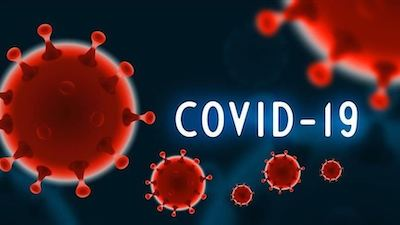

**Project: Detect Coronavirus From CT-Scan image**

**Date: Summer 2022**

**Developers:**


1.   Maedeh Mirzazadeh (@maedemir on [github](https://github.com/maedemir))
2.   Seyed Nami Modarressi (@SNamiMod on [github](https://github.com/SNamiMod))



# Step1: Loading and Visualizing the Dataset

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import cv2
import seaborn as sns
import numpy as np
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random
import time

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def load_dataset(path):
  dataset = []
  counter = 0
  number_of_data = len(os.listdir(path))
  for dir in sorted(os.listdir(path)):   # ploting first 10 images of the non-covid data
    imgPath = os.path.join(path, dir) 
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # saving images as RGB
    dataset.append(img)
  return number_of_data, dataset

In [7]:
def plot_dataset(dataset, num):
  counter = 0
  plt.figure(figsize = (5, 10)) # width = 5 inches and heighty = 10 inches
  for i, img in enumerate(dataset[:num]):
    ax = plt.subplot(5, 2, counter+1)
    plt.title(i+1)
    plt.imshow(img, cmap='gray', aspect = 'auto')
    plt.axis('off')
    counter += 1
  plt.subplots_adjust(hspace = 0.5, wspace = 0.1)  # hspace = vertical distance between images
  plt.show()                                       # wspace = horizental distance between images
  

## Let's see some samples of corona positive dataset

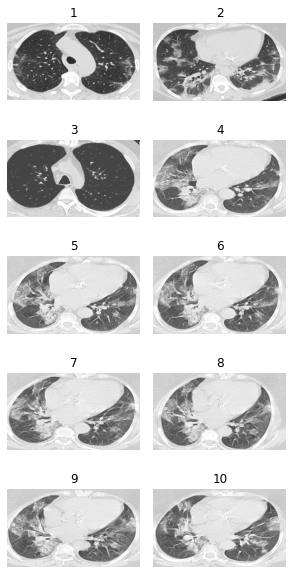



The number of images in positive corona dataset equals to 1252


In [8]:
covid_positive_path = '/content/drive/MyDrive/CT_IMAGES/CT_COVID' # Path of covid positive folder
cp_num, covid_positive_data = load_dataset(covid_positive_path)
plot_dataset(covid_positive_data, 10)
print(f'\n\nThe number of images in positive corona dataset equals to {cp_num}')

## and now some examples of corona negative dataset

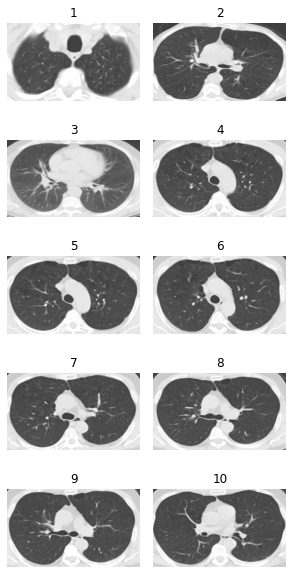



The number of images in negative corona dataset equals to 1229


In [9]:
covid_negative_path = '/content/drive/MyDrive/CT_IMAGES/CT_NonCOVID' #Path of covid negative folder
cn_num, covid_negative_data = load_dataset(covid_negative_path)
plot_dataset(covid_negative_data, 10)
print(f'\n\nThe number of images in negative corona dataset equals to {cn_num}')

# Step2: Data Pre-Processing 


1.   Resizing all images
2.   Split data to train(data and label) and test(data and label) --> 75% train , 25% test
3.   Normalization
4.   Data Augmentation

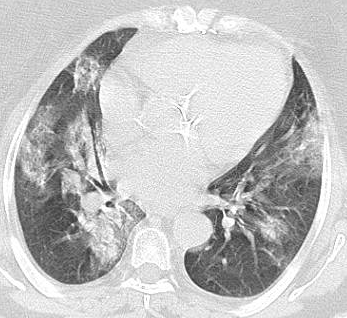

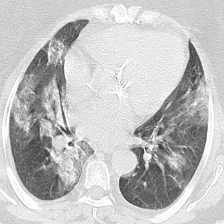

In [10]:
# resizing images
def resize(dataset):
  dim = (224, 224)   # VGG16 takes input tensor size as 224, 244 with 3 RGB channel
  result = []
  for im in dataset:
    result.append(cv2.resize(im, dim))
  return result

from google.colab.patches import cv2_imshow
cv2_imshow(covid_positive_data[10])
covid_positive_data = resize(covid_positive_data)
covid_negative_data = resize(covid_negative_data)
cv2_imshow(covid_positive_data[10])


In [11]:
# Split data to train, test

all_data = covid_positive_data + covid_negative_data

# label for positive corona = 1 , label for negative corona = 0
all_labels = [1] * len(covid_positive_data) + [0] * len(covid_negative_data)

all_data = np.array(all_data)/255

# splitting data to train and test(both labels and data)
x_train, x_test, y_train, y_test = train_test_split(all_data, all_labels, train_size = .8)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(1984, 224, 224, 3)
(1984, 2)
(497, 224, 224, 3)
(497, 2)


In [12]:
#  Data Augmentation
datagenerator = ImageDataGenerator(rotation_range=20,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   height_shift_range=0.2,  # vertical shift
                                   horizontal_flip=True  # horizontal flip
                                    )

# Step3: Buliding & Training our Model

In [13]:
InceptionV3_base_model = tf.keras.applications.InceptionV3(weights = 'imagenet',
                                         include_top = False,
                                         input_shape = (224,224,3))
for layer in InceptionV3_base_model.layers:
  layer.trainable = False

InceptionV3_base_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [14]:
outputs = InceptionV3_base_model.output
outputs = Flatten(name = "flatten")(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation="softmax")(outputs)
final_model = Model(inputs = InceptionV3_base_model.input, outputs = outputs)

adam =  tf.keras.optimizers.Adam()
final_model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
# Fit
batch_size1 = 32
epochs1 = 20
history = final_model.fit(datagenerator.flow(x_train, y_train, batch_size= batch_size1),
                    validation_data=(x_test, y_test),
                    validation_steps=len(x_test) / batch_size1,
                    steps_per_epoch=len(x_train) / batch_size1,
                    epochs= epochs1)

Epoch 1/20
62/62 [==============================] - 44s 439ms/step - loss: 1.1549 - accuracy: 0.7223 - val_loss: 1.3115 - val_accuracy: 0.6982
Epoch 2/20
62/62 [==============================] - 22s 359ms/step - loss: 1.0341 - accuracy: 0.7767 - val_loss: 0.8258 - val_accuracy: 0.7767
Epoch 3/20
62/62 [==============================] - 22s 356ms/step - loss: 1.0465 - accuracy: 0.7843 - val_loss: 0.8184 - val_accuracy: 0.8330
Epoch 4/20
62/62 [==============================] - 22s 359ms/step - loss: 1.0232 - accuracy: 0.8085 - val_loss: 0.7303 - val_accuracy: 0.8189
Epoch 5/20
62/62 [==============================] - 24s 390ms/step - loss: 1.0239 - accuracy: 0.8070 - val_loss: 0.6731 - val_accuracy: 0.8491
Epoch 6/20
62/62 [==============================] - 22s 361ms/step - loss: 0.9876 - accuracy: 0.8155 - val_loss: 0.7479 - val_accuracy: 0.8310
Epoch 7/20
62/62 [==============================] - 22s 360ms/step - loss: 1.0175 - accuracy: 0.8095 - val_loss: 0.6289 - val_accuracy: 0.8491

# Step4: Save and Evaluate the model

In [16]:
final_model.evaluate(x_test, y_test, batch_size1)

16/16 [==============================] - 2s 84ms/step - loss: 0.6928 - accuracy: 0.8793


[0.6928421258926392, 0.8792756795883179]

In [17]:
# Prediction
y_prediction = final_model.predict(x_test, batch_size=batch_size1)

# Convert to Binary classes
binary_y_test= np.argmax(y_test, axis=1)
binary_y_prediction = np.argmax(y_prediction, axis=1)

# Classification reports
print(classification_report(binary_y_test, binary_y_prediction))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       256
           1       0.86      0.90      0.88       241

    accuracy                           0.88       497
   macro avg       0.88      0.88      0.88       497
weighted avg       0.88      0.88      0.88       497



In [18]:
final_model.save('/content/drive/MyDrive/CT_IMAGES/InceptionV3_CT_model.h5')
final_model.save_weights('/content/drive/MyDrive/CT_IMAGES/InceptionV3_CT_model_wights.h5')

In [19]:
# loading our model
trained_model = load_model('/content/drive/MyDrive/CT_IMAGES/InceptionV3_CT_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


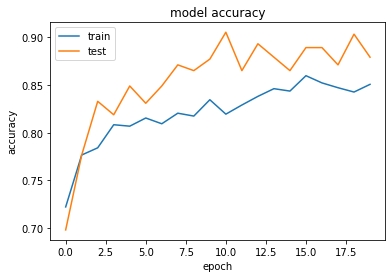

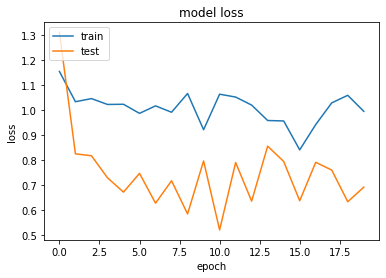

In [20]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

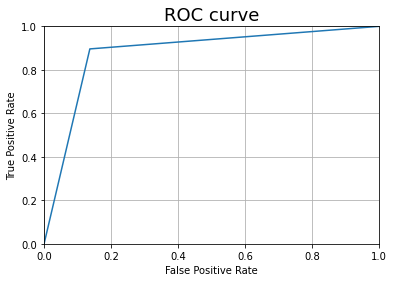

In [21]:
fpr, tpr, thresholds_keras = roc_curve(binary_y_test, binary_y_prediction)
auc_keras = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.rcParams['font.size'] = 15
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.grid(True)

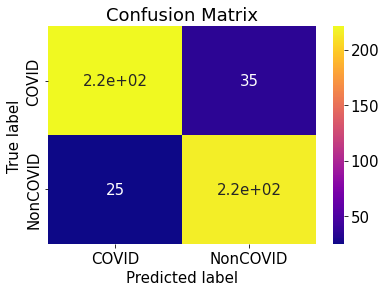

Confusion Matrix without Normalization


In [22]:
classes = ['COVID','NonCOVID']
tick_marks = [0.5,1.5]
confusionMatrix = confusion_matrix(binary_y_test, binary_y_prediction, normalize=None)
sns.heatmap(confusionMatrix, cmap='plasma',annot=True)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print('Confusion Matrix without Normalization')

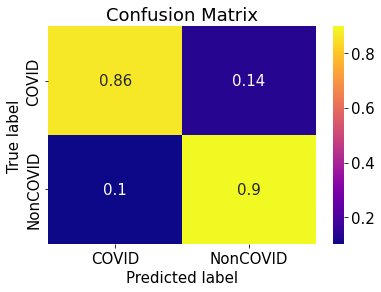

Confusion Matrix with Normalized Values


In [23]:
classes = ['COVID','NonCOVID']
tick_marks = [0.5,1.5]
confusionMatrix = confusion_matrix(binary_y_test, binary_y_prediction, normalize='true')
sns.heatmap(confusionMatrix, cmap='plasma',annot=True)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print('Confusion Matrix with Normalized Values')